In [18]:
"""
2025/07/21 Using the PINN loss function to solve the Neumann boundary value problem 
-\lap u + u = f in \Omega,
u = 0 on \partial\Omega, 
\Omega = (0,1) x (0,1) 

Exact solution: u = \sin(\pi x1)\sin(\pi x2)
f = (\pi^2 + 1)\sin(\pi x1)\sin(\pi x2)
author: Xiaofeng Xu 

log: July 25th Make the code dimension dependent 
"""
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
ZERO = torch.tensor([0.]).to(device)
B = 1 
C = 1   

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1
    def evaluate_2ndderivative(self,x,i,j): 
        if self.k == 2:
            u1 = self.fc2( 2 * torch.heaviside(self.fc1(x),ZERO) * (self.fc1.weight.t()[i-1:i,:])*self.fc1.weight.t()[j-1:j,:]) 
        else:
            u1 = self.fc2( self.k*(self.k-1)*F.relu(self.fc1(x))**(self.k-2) * (self.fc1.weight.t()[i-1:i,:])* (self.fc1.weight.t()[j-1:j,:]))  
        return u1


In [19]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    x_model_pt = x_model_pt[x_model_pt>=r1].reshape(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    # plt.plot(x_model_pt.cpu(),u_model_pt.cpu(),'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()

def show_convergence_order2_PINN(err_l2,err_h10,err_energy, exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    err_list3 = [err_energy[i] for i in neuron_nums ]
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \t\t order  \t\t energy err \t\t order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")s
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.3e} \t\t * \t\t {:.3e} \t\t * \t\t {:.3e} \t\t * \n".format(neuron_nums[i],item, err_list2[i],err_list3[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t *  \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i],err_list3[i] ))
        else: 
            print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2), 
                                                                            err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
                                                                             err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex2(err_l2,err_h10,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    l2_order = -1/2-(2*k + 1)/(2*d)
    h1_order =  -1/2-(2*(k-1)+ 1)/(2*d)
    print("neuron num  & \t $\|u-u_n \|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  & \t $ | u -u_n |_{{H^1}}$ & \t order $O(n^{{{:.2f}}})$  \\\ \hline \hline ".format(l2_order,h1_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )

def Neumann_boundary_quadrature_points(M, dim):
    """
    the boundary is in dimension dim - 1. 
    If 1D problem, the boundary is 0D, the quadrature points are 0 and 1. 
    """
    if dim == 1: 
        weights_bd = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd = torch.tensor([0.,1.]).view(-1,1).to(device) 
    
    return weights_bd.to(device), integration_points_bd.to(device) 



In [20]:

## 
# TODO
def minimize_linear_layer_PINN_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_D, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_bd_col = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_bd_col = basis_value_bd_col * weights_bd
    jac2 = weighted_basis_value_bd_col.t() @ (basis_value_bd_col)  # (u,v)_{\partial \Omega}

    # (Lu, Lv)_{\Omega} 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:
            assert False, "k must be at least 2"
        if model.k == 2:  
            basis_value_d11_col = 2 * torch.heaviside(integration_points @ w.t()+ b, ZERO) * (w.t()[0:1,:])**2 
            L_basis_col = - basis_value_d11_col + C * basis_value_col 
        else: 
            basis_value_d11_col = model.k * (model.k -1) * F.relu(integration_points @ w.t()+ b)**(model.k-2) * (w.t()[0:1,:])**2 
            L_basis_col = - basis_value_d11_col + C * basis_value_col 
        L_basis_col += B * model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * (w.t()[0:1,:]) 
        weighted_L_basis_col = L_basis_col * weights 
    jac1 =  weighted_L_basis_col.t() @L_basis_col 
    jac = jac1 + jac2

    rhs1 = weighted_L_basis_col.t() @ (target(integration_points) )

    # Dirichlet boundary (g,v)_{\partial \Omega}, g = 0 
    rhs2 = weighted_basis_value_bd_col.t() @ (g_D(integration_points_bd))
    rhs = rhs1 + rhs2 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

In [21]:

def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of dictionary elements 
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
       number of dictionary elements  
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
    """
    # w = 1 
    random_value = torch.randint(0, 2, (N,)) * 2 - 1 # +1 or -1  
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = random_value[:]
    relu_dict_parameters[:N,1] = (torch.rand(N)*(x_r-x_l) + x_l)*random_value # relu(x-bi) 

    return relu_dict_parameters


#TODO 
def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_D,weights_bd, integration_points_bd,k): 

    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values +=  - my_model.evaluate_2ndderivative(integration_points,1,1).detach() + C* my_model(integration_points).detach()  
        residual_values += B * my_model.evaluate_derivative(integration_points,1).detach() 
    weight_residual_values = residual_values*weights # 1. weights * ( Lu - f ) 

    basis_values = (F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**k) # uses broadcasting
    # output1 = torch.matmul(basis_values,weight_func_values) # 

    # ============TODO=========== DONE 
    # L (basis values)
    if k == 1:
        assert k>=2, "k must be at least 2"
    elif k == 2:  
        dbasis_values_d11 =  2 * torch.heaviside(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1], ZERO) * (relu_dict_parameters.t()[0:1,:])**2 
        Lg = - dbasis_values_d11 + C * basis_values

    else:  
        dbasis_values_d11 = k *(k-1) * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-2) * (relu_dict_parameters.t()[0:1,:])**2  
        Lg = - dbasis_values_d11 + C * basis_values 
    Lg += B * k * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-1) * (relu_dict_parameters.t()[0:1,:])   
    output2 = torch.matmul(Lg.t(), weight_residual_values) 
    #============TODO===========

    # Dirichlet boundary condition # 3. (u^{n-1},g)_{\partial \Omega}
    basis_values_bd_col = (F.relu(relu_dict_parameters[:,0] *integration_points_bd - relu_dict_parameters[:,1])**k) 
    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd
    # dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device)

    if my_model!= None:
        u_n_1 = my_model(integration_points_bd).detach()  
        output3 =  weighted_basis_value_col_bd.t() @ (u_n_1 - g_D(integration_points_bd)) 
        output = torch.abs(output2 + output3)
    else:
        g_bd = g_D(integration_points_bd)   
        output3 =  weighted_basis_value_col_bd.t() @ (- g_bd)
        output = torch.abs(output2 + output3)
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 


def OGANeumannReLU1D(my_model,target,u_exact,du_exact,g_D, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1,rand_deter = 'deter', solver = 'direct'): 
    """ Orthogonal greedy algorithm to solve a 1D Neumann problem 1D ReLU dictionary over [0,1]
    """

    integration_weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    err_energy = torch.zeros(num_epochs+1) # added 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        integration_weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(integration_weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*integration_weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*integration_weights)**0.5
        Lu = - my_model.evaluate_2ndderivative(integration_points,1,1).detach() +  C * my_model(integration_points).detach()
        Lu += B * my_model.evaluate_derivative(integration_points,1).detach() 
        energy  = 0.5 * integration_weights.t() @ ( Lu - target(integration_points) ) **2 \
                    + 0.5 * weights_bd.t() @ (my_model(integration_points_bd).detach() - g_D(integration_points_bd))**2  # added  
        err_energy[0] = energy  
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*integration_weights)**0.5
        energy  = 0.5 * integration_weights.t() @ target(integration_points)**2 + 0.5 * weights_bd.t() @ (g_D(integration_points_bd))**2 # add boundary energy 1/2 \int |u-g|^2 ds  # added  
        err_energy[0] = energy 

    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    if rand_deter == 'deter': 
        relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)
        if rand_deter == 'rand': 
            relu_dict_parameters = relu_dict_MC(0,1,N).to(device)    
        # start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,integration_weights, integration_points,g_D,weights_bd, integration_points_bd, k) 
        # print("argmax time: ", time.time() - start_argmax) 
        # print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]

        sol = minimize_linear_layer_PINN_neumann(my_model,target,integration_weights, integration_points,weights_bd, integration_points_bd,g_D,activation ='relu', solver = solver)
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*integration_weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*integration_weights)**0.5 
        Lu = - my_model.evaluate_2ndderivative(integration_points,1,1).detach() +  C * my_model(integration_points).detach()
        Lu += B * my_model.evaluate_derivative(integration_points,1).detach() 
        energy  = 0.5 * integration_weights.t() @ ( Lu - target(integration_points) ) **2  \
                    + 0.5 * weights_bd.t() @ (my_model(integration_points_bd).detach() - g_D(integration_points_bd))**2 # added  
        err_energy[i+1] = energy  
    print("time taken: ",time.time() - start_time)
    return err, err_h10,err_energy, my_model


## deterministic dictionary 

using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.00015687942504882812
solving Ax = b time taken:  5.078315734863281e-05
epoch:  2
assembling the matrix time taken:  0.00023436546325683594
solving Ax = b time taken:  6.222724914550781e-05
epoch:  3
assembling the matrix time taken:  0.0002830028533935547
solving Ax = b time taken:  6.103515625e-05
epoch:  4
assembling the matrix time taken:  0.00031495094299316406
solving Ax = b time taken:  5.125999450683594e-05
epoch:  5
assembling the matrix time taken:  0.00032210350036621094
solving Ax = b time taken:  5.078315734863281e-05
epoch:  6
assembling the matrix time taken:  0.00032806396484375
solving Ax = b time taken:  0.0001289844512939453
epoch:  7
assembling the matrix time taken:  0.0003509521484375
solving Ax = b time taken:  5.7697296142578125e-05
epoch:  8
assembling the matrix time taken:  0.0003218650817871094
solving Ax = b time taken:  5.316734313964844e-05
epoch:  9
assembling the matrix time take

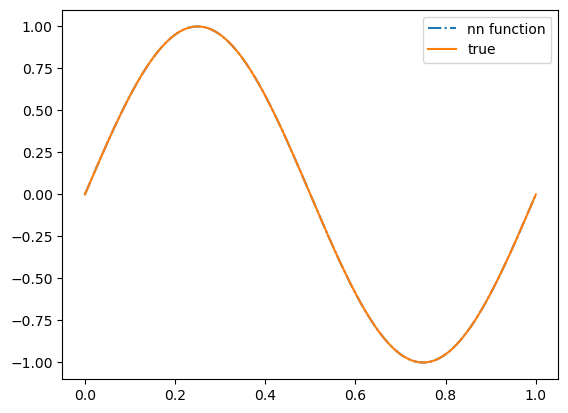

time taken:  5.364583969116211
neuron num 		 error 		 order
4 		 2.573e+00 		 * 		 1.225e+00 		 * 		 5.397e+01 		 * 

8 		 3.006e-01 		 3.10 		 1.730e-01 		 2.82 		 1.006e+00 		 5.75  

16 		 1.069e-03 		 8.14 		 4.649e-03 		 5.22 		 3.042e-02 		 5.05  

32 		 1.275e-05 		 6.39 		 3.948e-04 		 3.56 		 1.145e-03 		 4.73  

64 		 8.114e-06 		 0.65 		 3.566e-05 		 3.47 		 5.557e-05 		 4.36  

128 		 2.611e-07 		 4.96 		 4.399e-06 		 3.02 		 3.359e-06 		 4.05  



/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_17234/843720377.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_17234/843720377.py:78: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_17234/843720377.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipyke

In [22]:
m = 2 
def u_exact(x):
    return torch.sin(m*pi*x)

def du_exact(x):
    return m *pi*torch.cos(m*pi*x)

def rhs(x):
    return  (m*pi)**2 * torch.sin(m*pi*x) + C * u_exact(x) + B * du_exact(x)

def g_N(x):
    return du_exact(x) 

dim = 1 
function_name = "sine1d" 
filename_write = "data/1DPINNNeumannOGA-{}-order.txt".format(function_name)
Nx = 2**10 
order = 2  
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 

save = True 
write2file = True
rand_deter = 'deter'
for N in [2**10]: # 2**12,2**14
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 7 
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 3   
    err_QMC2, err_h10, err_energy, my_model = OGANeumannReLU1D(None,rhs,u_exact,du_exact,u_exact, N,num_epochs,plot_freq, Nx, order, k =relu_k, rand_deter = rand_deter,solver = "direct")

    if save: 
        folder = 'data/'
        filename = folder + 'err_NeumannOGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_NeumannOGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    show_convergence_order2_PINN(err_QMC2,err_h10,err_energy, exponent,2*N,filename_write,write2file = write2file)
    # show_convergence_order_latex2(err_QMC2,err_h10,exponent,k=relu_k,d = dim)



## cosine example 

using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.0001499652862548828
solving Ax = b time taken:  5.1021575927734375e-05
epoch:  2
assembling the matrix time taken:  0.0002677440643310547
solving Ax = b time taken:  5.793571472167969e-05
epoch:  3
assembling the matrix time taken:  0.00033164024353027344
solving Ax = b time taken:  0.0002009868621826172
epoch:  4
assembling the matrix time taken:  0.000270843505859375
solving Ax = b time taken:  5.1975250244140625e-05
epoch:  5
assembling the matrix time taken:  0.00030803680419921875
solving Ax = b time taken:  5.2928924560546875e-05
epoch:  6
assembling the matrix time taken:  0.0008039474487304688
solving Ax = b time taken:  0.0001609325408935547
epoch:  7
assembling the matrix time taken:  0.0003981590270996094
solving Ax = b time taken:  5.698204040527344e-05
epoch:  8
assembling the matrix time taken:  0.00030303001403808594
solving Ax = b time taken:  5.793571472167969e-05
epoch:  9
assembling the matri

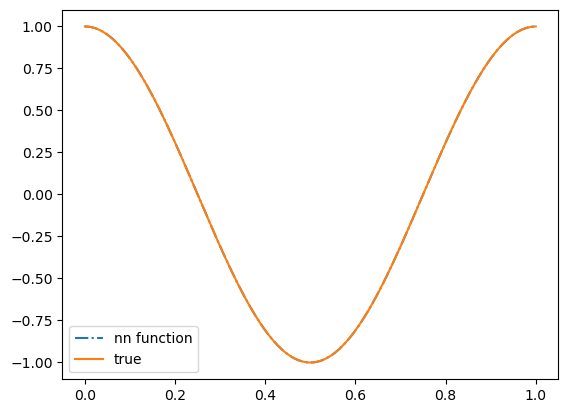

time taken:  21.15887999534607
neuron num 		 error 		 order
4 		 3.485e+00 		 * 		 3.840e+00 		 * 		 3.580e+01 		 * 

8 		 5.243e-01 		 2.73 		 3.933e-01 		 3.29 		 2.047e+00 		 4.13  

16 		 7.502e-03 		 6.13 		 9.892e-03 		 5.31 		 7.687e-02 		 4.74  

32 		 9.893e-05 		 6.24 		 3.682e-04 		 4.75 		 1.274e-03 		 5.92  

64 		 8.696e-06 		 3.51 		 3.859e-05 		 3.25 		 7.589e-05 		 4.07  

128 		 1.776e-06 		 2.29 		 5.242e-06 		 2.88 		 5.187e-06 		 3.87  

256 		 2.858e-07 		 2.64 		 1.329e-06 		 1.98 		 3.175e-07 		 4.03  



/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_17234/843720377.py:77: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_17234/843720377.py:78: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_17234/843720377.py:79: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipyke

In [23]:
m = 2 
def u_exact(x):
    return torch.cos(m*pi*x)

def du_exact(x):
    return -m *pi*torch.sin(m*pi*x)

def rhs(x):
    return  ((m*pi)**2 + C) * torch.cos(m*pi*x)  + B * du_exact(x) 

dim = 1 
function_name = "cosine1d" 
filename_write = "data/1DPINNNeumannOGA-{}-order.txt".format(function_name)
Nx = 2**10 
order = 2  
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 

save = True 
write2file = True
rand_deter = 'deter'
for N in [2**11]: # 2**12,2**14
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 8 
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 3   
    err_QMC2, err_h10, err_energy, my_model = OGANeumannReLU1D(None,rhs,u_exact,du_exact,u_exact, N,num_epochs,plot_freq, Nx, order, k =relu_k, rand_deter = rand_deter,solver = "direct")

    if save: 
        folder = 'data/'
        filename = folder + 'err_NeumannOGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_NeumannOGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    show_convergence_order2_PINN(err_QMC2,err_h10,err_energy, exponent,2*N,filename_write,write2file = write2file)
    # show_convergence_order_latex2(err_QMC2,err_h10,exponent,k=relu_k,d = dim)

